# EV Battery Capacity

![A shiny brown BMW model I3 electric car, charging in a garage using a cable connected to an outlet](ev.jpg)

Electric cars have gotten significantly more popular, with Teslas and other electric vehicles becoming a common sight. A commonality between all types of EVs is the battery, which must be charged because it depletes during use. Battery capacity is a measure of a battery's ability to produce continuous power from a charge, which is similar to the max fuel capacity of a gasoline-powered car.

## The Data

I found a dataset which has numerous charging characteristics, where each row represents a single charge by a certain EV and its owner. I am only focusing on battery capacity (in Kilowatt Hours).

In [1]:
import pandas as pd

In [2]:
data_set = pd.read_csv("ev_charging_patterns.csv")
data = data_set["Battery Capacity (kWh)"]
data

0       108.463007
1       100.000000
2        75.000000
3        50.000000
4        50.000000
           ...    
1315    100.000000
1316    100.000000
1317    100.000000
1318     85.000000
1319    120.447195
Name: Battery Capacity (kWh), Length: 1320, dtype: float64

<Axes: >

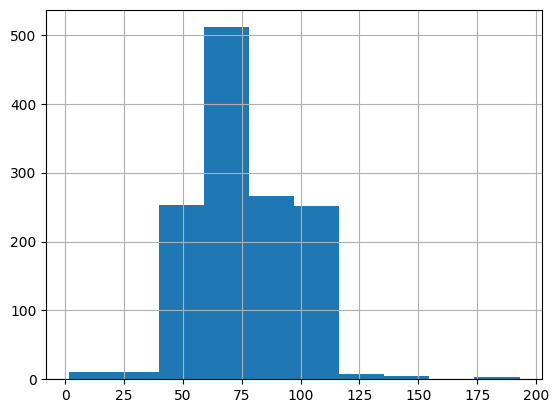

In [3]:
data.hist()

This histogram shows that most of the data is in the range between 25 and 125 and is skewed left. There are very few data points that lie outside the main distribution, although there is a small portion in the range between 125 and 200.

## Initial Plunge

I decided to try the Skewed Student-t Distribution after perusing the PreliZ documentation. It seems to be able to represent a skewed curve, as well as allowing the shape to match the sudden drops that we see in the data. Importantly, it is a continuous distribution, can be skewed, and supports at least positive real numbers. I experimented with this distribution to get a feel for what each of the parameters does:

In [4]:
import preliz as pz

In [5]:
pz.SkewStudentT().plot_interactive()

interactive(children=(FloatSlider(value=0.0, description='mu (-inf, inf)', max=10.0, min=-10.0, style=SliderSt…

In this distribution:

- `mu` - $\mu$ is the location parameter, controlling the location of the distribution along the axis
- `sigma` - $\sigma$ is the scale parameter, describing the curve's "flatness"
- `a` and `b` control the shape of the curve and affect its skewness

### The Priors

The priors should match my prior knowledge. I know little about EV's, so I want a weak prior. I do know that generally, there is a range of values that automakers make batteries for, and that the probability of finding a vehicle outside that range will be low. I will use this logical knowledge to decide what distributions to choose for my prior.

For a first experiment, I decided to make the priors all uniform. This doesn't model my assumptions. I just wanted to perform a test run before continuing.

In [6]:
import pymc as pm

In [7]:
with pm.Model() as model1:
    ### PRIORS ###
    # Don't mind the uniform distributions. This was a first trial, so the priors in this test
    # were not yet based on my actual assumptions.
    mu = pm.Uniform("μ", lower=0, upper=200)
    sigma = pm.Uniform("σ", lower=0, upper=100)
    a = pm.Uniform("a", lower=0, upper=100)
    b = pm.Uniform("b", lower=0, upper=100)

    ### POSTERIOR ###
    y = pm.SkewStudentT("y", mu=mu, sigma=sigma, a=a, b=b, observed=data)
    data1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, a, b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


In [8]:
pm.sample_posterior_predictive(data1, model=model1, extend_inferencedata=True) # Posterior predictive check

Sampling: [y]


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

### The PPC

In [9]:
import arviz as az

<Axes: xlabel='y'>

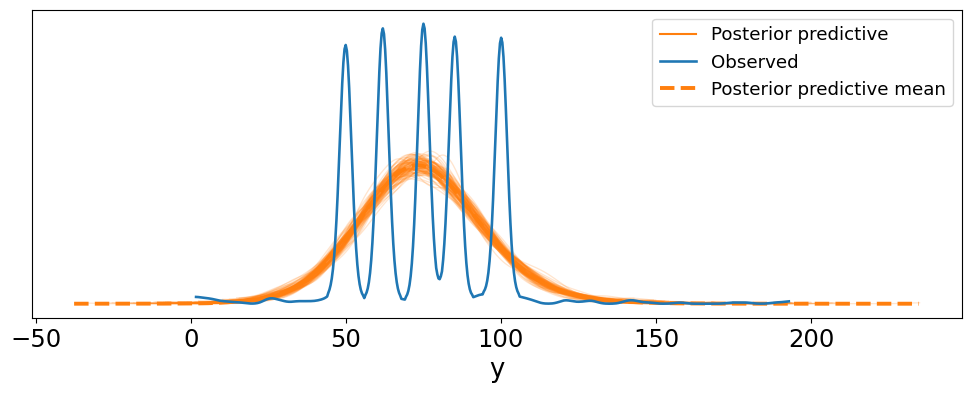

In [10]:
az.plot_ppc(data1, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

AAAA!

First of all, the posterior predictive does not seem like a good match to the data set. Notice that the curve doesn't even come up to the top of the observed data, and doesn't match the shape. This was to be expected, considering I used dummy priors.

The bigger result of this test run is that the data is completely different from what I had expected it to look like. Notice the blue (observed) curve is multimodal, with 5 distinct peaks. This curve cannot be accurately modeled with the current tools available to us.

I accidentally stumbled upon the fact that there seem to be five discrete values for EV battery capacity, and everything else is just variation from discreteness. To confirm, I plotted a kernel density estimation (KDE) of the data set:

<Axes: ylabel='Density'>

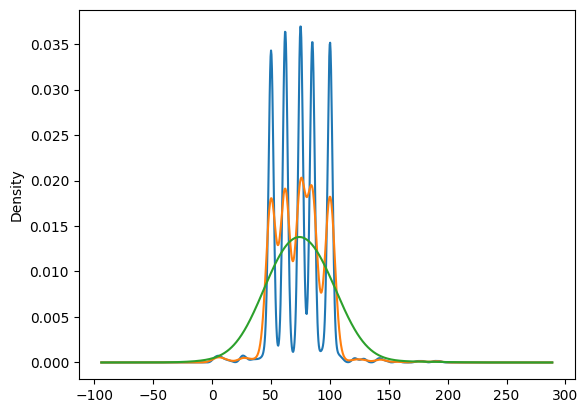

In [11]:
data.plot(kind='kde', bw_method=0.1); data.plot(kind='kde', bw_method=0.2); data.plot(kind='kde', bw_method=1)

For reference, the KDE of the chemshift data looked like a smoother curve, even at smaller values for `bw_method` (the *bandwidth* parameter). Notice that if we use a rougher estimation of the distribution density, the curves go away. Essentially, a histogram does the same thing: the histogram masked the true nature of the dataset, making it look like a single-mode distribution.

The image below is an example of the difference between how histograms and KDEs are calculated. *Note that this example is not related to my data.* Source: Drleft at English Wikipedia, CC BY-SA 3.0, <https://commons.wikimedia.org/w/index.php?curid=57332968>

![On the left is a histogram of a dataset. On the right is a KDE for the same data set, composed of normal kernels with a 1.5 standard deviation.](kde-histogram.png)

The reason for this curve seems to be that car battery capacities come in 5 different discrete capacities, and the slight variation is caused by slight variation from those 5 types.

At this point, there are two things I can do. First, I can model *all* the data using a discrete distribution, but that requires discrete values. Unfortunately, my data points themselves are decimal values that vary from the fixed capacities. Second, I can attempt to filter a *subset* of the data in order to isolate on of the five curves, and explore from there. This is what I'll choose to do, but it might not succeed (I need a strategy to extract one of the curves).

## Analyzing a data subset

Now I am back at the drawing board. The whole data set actually has many different columns that associate specific data to each charge. Perhaps if I filter by a factor by vehicle type, I will be able to isolate a single one of those curves.

In [12]:
data_set

,User ID,Vehicle Model,Battery Capacity (kWh),Charging Station ID,Charging Station Location,Charging Start Time,Charging End Time,Energy Consumed (kWh),Charging Duration (hours),Charging Rate (kW),Charging Cost (USD),Time of Day,Day of Week,State of Charge (Start %),State of Charge (End %),Distance Driven (since last charge) (km),Temperature (°C),Vehicle Age (years),Charger Type,User Type
0,User_1,BMW i3,108.463007,Station_391,Houston,2024-01-01 00:00:00,2024-01-01 00:39:00,60.712346,0.591363,36.389181,13.087717,Evening,Tuesday,29.371576,86.119962,293.602111,27.947953,2.0,DC Fast Charger,Commuter
1,User_2,Hyundai Kona,100.000000,Station_428,San Francisco,2024-01-01 01:00:00,2024-01-01 03:01:00,12.339275,3.133652,30.677735,21.128448,Morning,Monday,10.115778,84.664344,112.112804,14.311026,3.0,Level 1,Casual Driver
2,User_3,Chevy Bolt,75.000000,Station_181,San Francisco,2024-01-01 02:00:00,2024-01-01 04:48:00,19.128876,2.452653,27.513593,35.667270,Morning,Thursday,6.854604,69.917615,71.799253,21.002002,2.0,Level 2,Commuter
3,User_4,Hyundai Kona,50.000000,Station_327,Houston,2024-01-01 03:00:00,2024-01-01 06:42:00,79.457824,1.266431,32.882870,13.036239,Evening,Saturday,83.120003,99.624328,199.577785,38.316313,1.0,Level 1,Long-Distance Traveler
4,User_5,Hyundai Kona,50.000000,Station_108,Los Angeles,2024-01-01 04:00:00,2024-01-01 05:46:00,19.629104,2.019765,10.215712,10.161471,Morning,Saturday,54.258950,63.743786,203.661847,-7.834199,1.0,Level 1,Long-Distance Traveler
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,User_1316,Nissan Leaf,100.000000,Station_57,New York,2024-02-24 19:00:00,2024-02-24 20:30:00,42.011654,1.426444,5.895475,22.081164,Evening,Sunday,39.204102,83.915952,239.601075,1.919655,7.0,DC Fast Charger,Commuter
1316,User_1317,BMW i3,100.000000,Station_40,New York,2024-02-24 20:00:00,2024-02-24 20:44:00,68.185853,3.238212,18.388012,5.067806,Evening,Tuesday,31.456375,93.096461,164.376022,34.029775,4.0,Level 2,Casual Driver
1317,User_1318,Nissan Leaf,100.000000,Station_374,New York,2024-02-24 21:00:00,2024-02-24 23:03:00,18.895102,3.267122,45.482066,37.255002,Evening,Tuesday,71.903081,78.678879,226.519258,20.358761,5.0,DC Fast Charger,Commuter
1318,User_1319,Chevy Bolt,85.000000,Station_336,San Francisco,2024-02-24 22:00:00,2024-02-24 23:20:00,13.756252,2.754527,38.148183,39.046146,Afternoon,Sunday,76.187997,65.926573,291.494076,24.134598,5.0,Level 2,Commuter


I decided to try filtering by `Vehicle Model`. This is the make and model of the vehicle used at a given charge. Given that there are five distinct capacities, I am guessing that each car type has a single type of battery capacity of those five.

<Axes: ylabel='Density'>

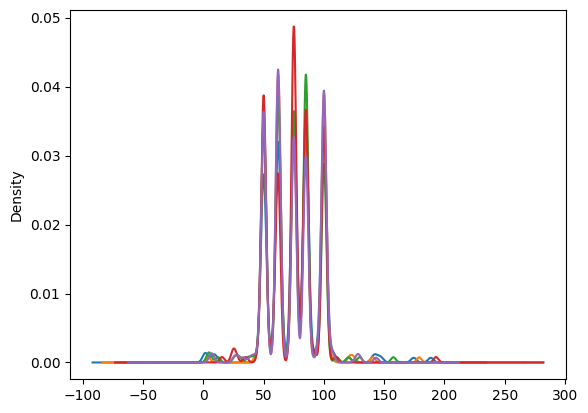

In [13]:
# Here, I am filtering by vehicle model and then plotting its battery capacity KDE.
data_set.loc[data_set["Vehicle Model"] == "BMW i3"]["Battery Capacity (kWh)"].plot(kind="kde", bw_method=0.1)
data_set.loc[data_set["Vehicle Model"] == "Hyundai Kona"]["Battery Capacity (kWh)"].plot(kind="kde", bw_method=0.1)
data_set.loc[data_set["Vehicle Model"] == "Nissan Leaf"]["Battery Capacity (kWh)"].plot(kind="kde", bw_method=0.1)
data_set.loc[data_set["Vehicle Model"] == "Chevy Bolt"]["Battery Capacity (kWh)"].plot(kind="kde", bw_method=0.1)
data_set.loc[data_set["Vehicle Model"] == "Tesla Model 3"]["Battery Capacity (kWh)"].plot(kind="kde", bw_method=0.1)

Nope. Notice that all five cars (denoted by different colors) still have five peaks. Importantly, all follow the exact five values, although the height of each curve (density) is different for each car model.

Of the five car types I experimented with, all follow the same five values. My theory is that as battery capacity depletes over time, a car will round it to the closest of five values. However, I am unsure if this is the case. I would have to do more research about electric vehicles.

## Conclusion

At this point I am calling it a day. In my attempt to make a model, I ended up making a much larger discovery about the data set. This revealed something about electric vehicles that I didn't know before starting the project.

I believe that had the curve looked like my assumption from the histogram, a Skew Student's-T distribution would be ideal. Additionally, my choice of a weak prior would have been justified, judging by my electric vehicle knowledge.

However, it turns out the data is too complicated to analyze as a whole at this point in the course. To circumvent this, I tried to isolate a specific curve, but to no avail.

From the project, I can conclude that EV battery capacity is more complicated than it seems. It clusters around 5 discrete values, irrespective of the car make and model. I will keep this data set to use in a future project when we will have the tools to make more specific observations.

## Sources

- [Kernel Density Estimation - Wikipedia](https://en.wikipedia.org/wiki/Kernel_density_estimation)
- [Histograms vs. KDEs Explained](https://towardsdatascience.com/histograms-vs-kdes-explained-ed62e7753f12)
- [EV battery size, charge speeds and range explained](https://www.techradar.com/news/ev-battery-size-charge-speeds-and-range-explained)